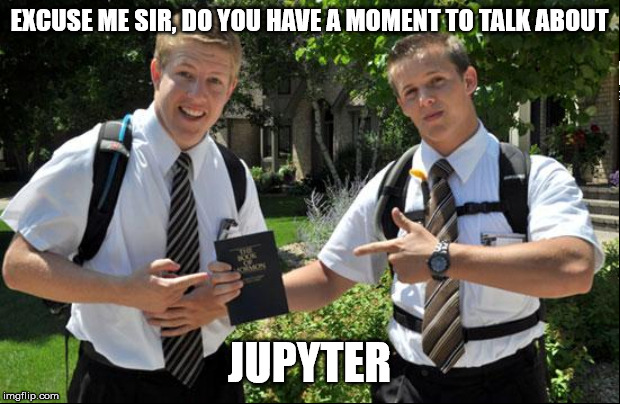  


# Table of Contents
[1. Important Links](#Important-Links)  
[2. About Jupyter](#About-Jupyter)  
[3. Why Use Jupyter](#Why-Use-Jupyter)  
[4. Scenario](#Scenario)  

# Important Links
- Jupyter: `https://jupyter.org/`
- Jupyter Hub: `https://jupyterhub.readthedocs.io/en/stable/`
- The Littlest JupyterHub: `https://tljh.jupyter.org/en/latest/`
- Github Pages: `https://pages.github.com/`
- Run Jupyter in Cloud for Free: `https://www.dataschool.io/cloud-services-for-jupyter-notebook/`
- SoS: `https://vatlab.github.io/sos-docs/`

# About Jupyter
Jupyter is an IDE, much like Rstudio or VScode, which developed from IPython (hence the `.ipynb` extension for jupyter files). But unlike most IDEs, jupyter is a web-application whose entire focus is data analysis and visualization. For those that used Rmarkdown, you can think of it as a more functional, dynamic, and powerful version (No need to render the .Rmd file in order to see the final output). 

There are two versions of Jupyter available for single-users (e.g. `Jupyter Notebook` and `Jupyterlab`). The latter is the newer version and essentially provides a more traditional IDE environment (e.g. allows users to have multiple windows). Once installed, jupyter will set up a `local` server, which you can access through your web-browser. If one requires a `global` server (perhaps you are teaching a programming course) one can use `jupyterhub`. This brownbag session is being hosted on Google Cloud using `The Littlest Jupyterhub`, which was designed for a small amount of users (less than 100). In total, it took about 15 minutes for me to get everything running.

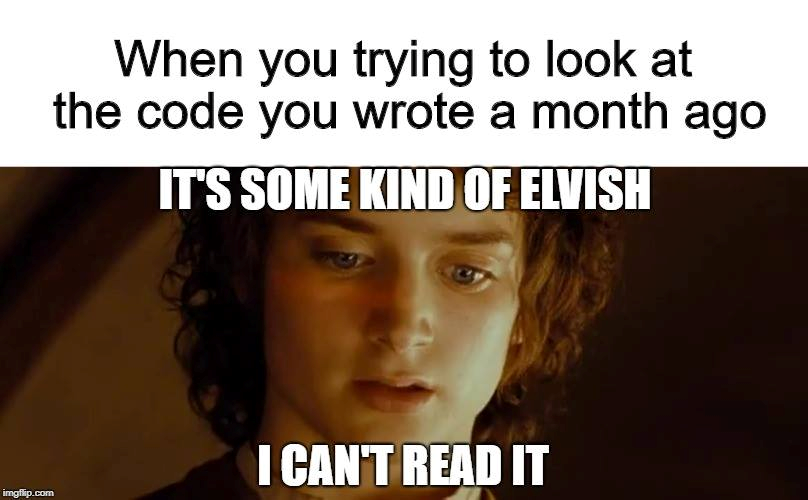  

# Why Use Jupyter
- **Easy to create a narrative**. As Jupyter support markdown, it is very easy to insert images, provide links, highlight words, and add fancy schmancy math equations (e.g. $ sum_{k=1}^n a_k b_k^2 $ ). This allows you to essentially tell a story, which may be difficult with comments alone.
- **It's incredibly portable**. If one opens this `.ipynb` file in a text-editor, you will noticed **everything** is stored within the file (even the images). But more importantly, these files are **JSON** files. In other words, everything is human-readable and can be retrieved without additional software. Thus, there is no need to worry about your code becoming "locked" within a certain platform. 
- **Easy to share**. Many sites, like `github pages` will automatically render your jupyter notebooks in HTML for free. If you prefer to host your own content, there are many static site builders (e.g. Pelican, Nikola, Hugo, etc) that will convert the `.ipynb` files into `.html` files with ease. Additionally, many of the cloud providers will also allow you to run your jupyter notebooks for free (See links section).
- **Magic**. Many of the Jupyter kernels (e.g. IPython for python) have magic commands, which add functionality to the notebooks without writing a bunch of code. Want to know how much memory your code is taking? Want to be able to pass commands to the command prompt? Perhaps you want a debugger? Don't fret, there's a magic command for all of that (and more) and all you need to do is type a keyword. 
- **Countless Extensions**. As Jupyter is a web-application, it's very easy for web developers to write extensions for Jupyter in JavaScript. As such, there are a ton of extensions that help with auto-formatting, notifying you when your code has completed, importing programs from other notebooks and files, etc. One particularly helpful extension is `SoS` (Script of Scripts), which allows users to transport data-structures between different programming languages. It even provides a workflow engine, which will help you submit jobs to a cluster. 

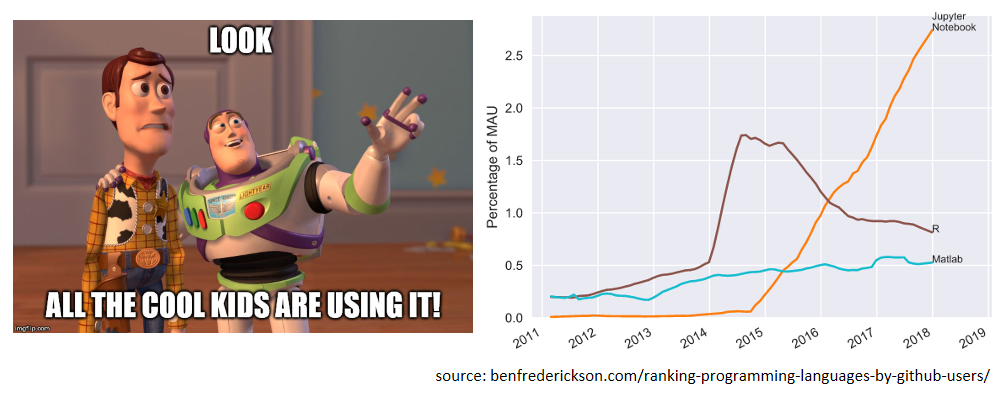

# Scenario  
You are interested in completing an eQTL (expression quantitative trait loci) analysis on a gene of interest. This gene is found on chromosome 3. Your colleague has provided you with the necessary files to complete this analysis.  
- 200115_SNPs.csv: Contains SNPs (single nucleotide polymorphism) on chromosome 3. 
- 200115_Annotations.csv: Contain SNP positions for chromosome 3.
- 200115_Expression.csv: Contains the expression of the gene of interest
- 200115_PCs.csv: Contains a list of the top 3 principal components (needed for adjusting eQTL model).

**Problem**
- The genotypic information has not been processed. It needs to be hardcoded, checked for monomorphic SNPs, checked for excessive NAs, and pruned for SNPs 500kb from the start/end of the gene. 

**Plan of Action**: While R is perfectly capable of data-wrangling, you've heard about this programming language called python and decided to try it out.

In [1]:
import pandas as pd# Python's version of the tidyverse
import numpy as np # Used to define NaN values
from pathlib import Path # Avoids OS-specific file reading/writing errors 

# Step 1. Create annotation dict that will store positions
anno_dict = {}
with open(Path(r'data/200115_SNP_Annotations.csv'), 'r') as f_in:
    next(f_in) # Skip header
    
    for line in f_in:
        split_line = line.strip().split(',')
        rs_id = split_line[0]
        pos = split_line[2]
        anno_dict[rs_id] = int(pos)
        
# Step 2. Create functions that will validate/process genotypic data
def recode(SNPs, threshold = 0.1):
    
    recoded_SNPs = [SNPs[0]] # Holds recoded values
    
    for dose in SNPs[1::]: # First value ignored, as it is the snpid 
        value = float(dose)
        allele_1 = value 
        allele_2 = (2 - value)
        allele_1_rounded = round(allele_1)
        allele_2_rounded = round(allele_2)
        
        x = (0.5 * (abs(allele_1 - allele_1_rounded) + abs(allele_2 - allele_2_rounded)))
        
        if x >= threshold:
            recoded_SNPs.append("NA")
        else:
            if (allele_1_rounded == 0):
                recoded_SNPs.append(0)
            elif (allele_1_rounded == 1):
                recoded_SNPs.append(1)
            else:
                recoded_SNPs.append(2)

    return recoded_SNPs

def is_monomorphic(SNPs):
    if (SNPs[1] == 0) and ( all([(elem == 0) or (elem == "NA") for elem in SNPs[1::]]) ):
        return True
    elif (SNPs[1] == 2) and ( all([(elem == 2) or (elem == "NA") for elem in SNPs[1::]]) ):
        return True
    else:
        return False
    
def excessive_NAs(SNPs, threshold = 5):
    if SNPs.count("NA") > 20:
        return True
    else:
        return False
    
def not_in_range(SNPs, distance = 500_000, start = 119_316_694, stop = 119_348_658):
    pos = anno_dict[SNPs[0]]
    if (start - distance) <= pos <= (stop + distance):
        return False
    else:
        return True

# Step 3. Process genotypic data 
header = []
SNPs = []
count = 0
with open(Path(r'data/200115_SNPs.csv'), 'r') as f_in:
    header = next(f_in).strip().split(',')
    
    for line in f_in:
        split_line = line.strip().split(',')
        
        # recode SNPs
        hardcoded_SNPs = recode(split_line)

        # Check for monomorphic SNPs
        if is_monomorphic(hardcoded_SNPs):
            #print(f"{hardcoded_SNPs[0]} was found to be monomorphic and disregarded")
            count += 1
            continue 
            
        # Check for excessive NAs 
        if excessive_NAs(hardcoded_SNPs):
            #print(f"{hardcoded_SNPs[0]} was found to have excessive NAs")
            count += 1
            continue 
        
        # Check that SNP is in cis 
        if not_in_range(hardcoded_SNPs):
            #print(f"{hardcoded_SNPs[0]} was out of range")
            count += 1
            continue
            
        # If SNP is valid, add it to SNP list
        SNPs.append(hardcoded_SNPs)
        

    print(f"{count} SNPs were removed during processing.")


# Step 4. Load it into a pandas dataframe 
df = pd.DataFrame(SNPs, columns = header)
df = df.replace("NA", np.nan)
df = df.set_index("snpid")
df.head()

156 SNPs were removed during processing.


,1,2,3,4,5,6,7,8,9,10,...,53,54,55,56,57,58,59,60,61,62
snpid,,,,,,,,,,,,,,,,,,,,,
rs0084,1.0,1.0,1.0,1.0,0.0,2.0,0,1.0,1.0,1,...,1.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0
rs0085,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
rs0086,0.0,1.0,2.0,2.0,0.0,2.0,0,1.0,2.0,1,...,1.0,0.0,NaN,0.0,1.0,0.0,1.0,1.0,1.0,1.0
rs0087,2.0,1.0,2.0,2.0,1.0,2.0,0,1.0,2.0,1,...,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0
rs0088,0.0,1.0,2.0,2.0,0.0,2.0,0,1.0,2.0,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0


Pandas are essentially python's version of the tidyverse. They are quite powerful and great for visualization. For instance, perhaps you wanted to highlight all NA values.

In [2]:
df.head().style.applymap(lambda x: 'background: yellow' if pd.isnull(x) else '')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
snpid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rs0084,1,1,1,1,0,2,0,1,1,1,1,2,1,2,nan,2,2,2,0,1,2,1,1,0,2,2,0,2,1,1,0,2,1,2,1,1,2,0,0,2,1,1,0,1,2,1,0,1,1,1,2,1,1,1,1,0,2,1,1,0,1,1
rs0085,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,0,1,2,0,1,1,1,0,0,1,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0
rs0086,0,1,2,2,0,2,0,1,2,1,2,0,0,2,1,2,1,1,0,2,0,1,0,0,2,1,0,2,1,0,0,0,nan,1,0,0,2,1,1,2,0,2,0,0,1,0,0,0,nan,1,1,0,1,0,nan,0,1,0,1,1,1,1
rs0087,2,1,2,2,1,2,0,1,2,1,2,2,1,2,2,2,2,1,2,2,2,1,2,1,2,2,1,2,1,1,1,1,2,1,1,nan,2,1,1,2,1,2,1,2,2,2,1,1,2,1,2,2,1,1,2,1,2,1,2,2,1,2
rs0088,0,1,2,2,0,2,0,1,2,1,2,0,0,2,1,2,1,1,0,2,0,1,0,0,2,1,0,2,1,0,0,0,2,1,0,0,2,1,1,2,0,2,0,1,1,0,0,0,2,1,1,0,1,0,1,0,1,0,1,1,1,2


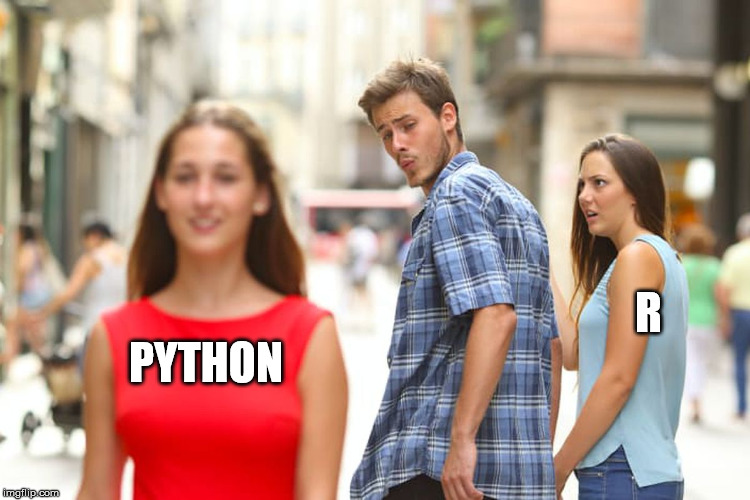

Now that you processed the data, you want to do the actual eQTL analysis. As you've been using R for some time now, you feel more comfortable in that environment.

In [3]:
%get df --from Python3

# We are now using R!
head(df) 

,1,2,3,4,5,6,7,8,9,10,...,53,54,55,56,57,58,59,60,61,62
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs0084,1,1,1,1,0,2,0,1,1,1,...,1,1,1,0,2,1,1,0,1,1
rs0085,0,1,1,0,0,0,0,0,0,0,...,1,1,1,0,1,0,1,0,0,0
rs0086,0,1,2,2,0,2,0,1,2,1,...,1,0,NA,0,1,0,1,1,1,1
rs0087,2,1,2,2,1,2,0,1,2,1,...,1,1,2,1,2,1,2,2,1,2
rs0088,0,1,2,2,0,2,0,1,2,1,...,1,0,1,0,1,0,1,1,1,2
rs0089,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


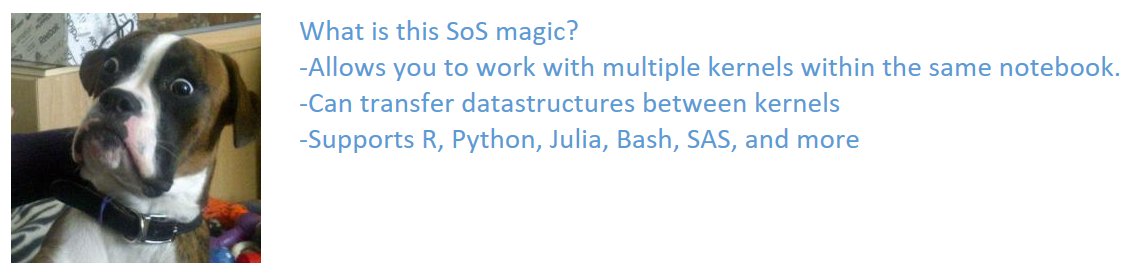

In [4]:
# Grab expression values
expression <- read.csv('data/200115_Expression.csv', check.names = F, row.names = 1)
expression <- as.numeric(expression[1,])


# Grab PCs
PCs <-read.csv('data/200115_PCs.csv', check.names = F, row.names = 1)
PCs <- as.matrix(PCs[c(1,2,3)])

results <- data.frame(rsid = character(), p_value = double())

for (i in 1:nrow(df)){
    model <- model <-  lm(expression ~ as.numeric(df[i,]) + PCs)
    temp_results <- summary(model)
    temp_df <- data.frame(rsid = row.names(df[i,]), p_value = temp_results$coefficients[2,4])
    results <- rbind(results, temp_df)
}

# Show top results
head(results[order(results$p_value),])

,rsid,p_value
,<fct>,<dbl>
56,rs0139,0.002381878
18,rs0101,0.015781389
29,rs0112,0.015781389
62,rs0145,0.039406720
63,rs0146,0.039406720
66,rs0149,0.042946323


As you can see, we have several results below significance (defined at 0.05). But as we conducted multiple tests, we should do some sort of correction. Let's apply an FDR correction.

In [5]:
results$p_value <- p.adjust(results$p_value, method='fdr', n=length(results$p_value))
head(results[order(results$p_value),])

,rsid,p_value
,<fct>,<dbl>
56,rs0139,0.2143690
18,rs0101,0.4734417
29,rs0112,0.4734417
16,rs0099,0.4927029
20,rs0103,0.4927029
43,rs0126,0.4927029


Unfortunately, our significant results were likely a type I error. But let's go ahead and visualize the top result. And since ggplot is wonderful, we will use that.

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


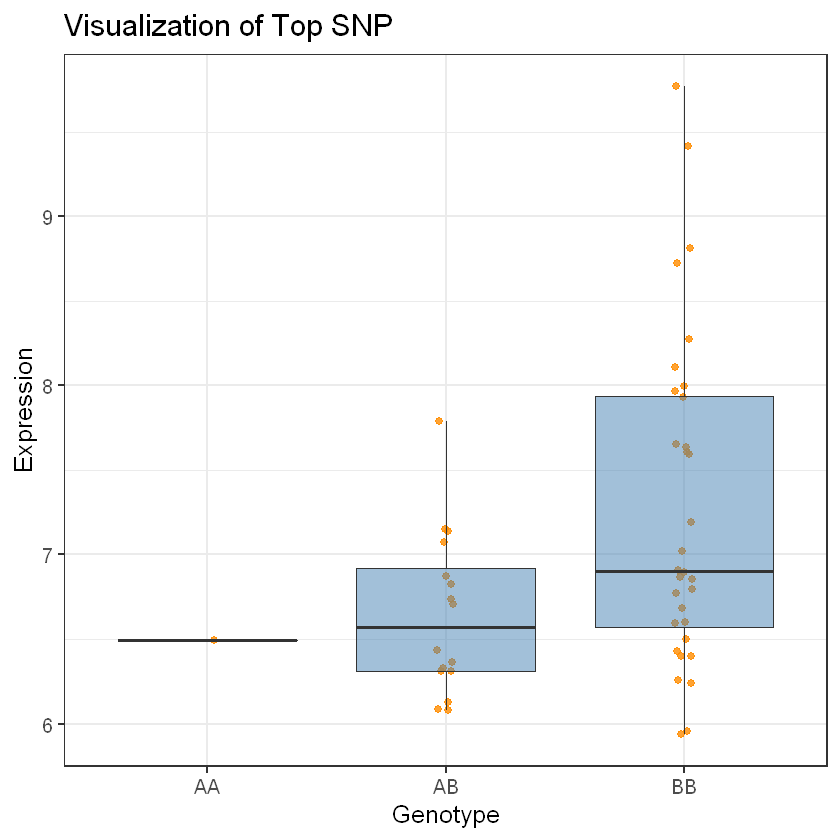

In [6]:
library(tidyverse)
SNPs <- t(df['rs0139',])
SNPs <- as.factor(SNPs)
expression <- data.frame(expression)
combined_df <- cbind(expression, SNPs)
combined_df <- drop_na(combined_df)
colnames(combined_df) <- c('Expression', 'Genotype')

ggplot(combined_df, aes(Genotype, Expression)) +
  geom_jitter(colour = "darkorange",alpha = 0.8, width = 0.04, size=2) +
  geom_boxplot(alpha = 0.5, fill = "steelblue", 
               position = position_dodge(width = 0)) +
  theme_bw(base_size = 15) + 
  scale_x_discrete(labels = c('AA','AB','BB')) +
  labs(x = 'Genotype', y = 'Expression', title='Visualization of Top SNP')